In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-darkgrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('covid_19_clean_complete.csv', parse_dates=['Date'])

# Analyse the data for SG
sg = data.loc[data['Country/Region'] == 'Singapore', ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
sg.columns = ['country', 'date', 'confirmed', 'deaths', 'recovered']

# Group by country and date
sg.groupby(['country', 'date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

sg.date = pd.to_datetime(sg.date)
sg = sg.sort_values(by = 'date')
sg.tail()

,country,date,confirmed,deaths,recovered
40388,Singapore,2020-06-24,42623,26,36299
40649,Singapore,2020-06-25,42736,26,36604
40910,Singapore,2020-06-26,42955,26,36825
41171,Singapore,2020-06-27,43246,26,37163
41432,Singapore,2020-06-28,43459,26,37508


In [3]:
# We can view the countries with the most cases

data.loc[data['Date'] == '2020-06-28', ['Country/Region', 'Confirmed']].sort_values(by='Confirmed', ascending=False)[:7]

,Country/Region,Confirmed
41461,US,2548996
41266,Brazil,1344143
41423,Russia,633563
41367,India,548318
41459,United Kingdom,311151
41417,Peru,279419
41285,Chile,271982


In [4]:
# View the time series data as a whole

def create_country_df(country, end_date = '2020-06-28'):
  df = data.loc[data['Country/Region'] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
  df.columns = ['country', 'date', 'confirmed', 'deaths', 'recovered']

  df.groupby(['country', 'date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()
  df.date = pd.to_datetime(df.date)
  df = df.sort_values(by='date')
  df = df[df.date <= end_date]

  # create daily cases
  day_before = np.array([0]+list(df['confirmed'][:-1]))
  daily_confirmed = np.array(df['confirmed']) - day_before
  df['daily_confirmed'] = daily_confirmed

  # create rolling mean
  df['rolling_mean'] = df['daily_confirmed'].rolling(window=4).mean()

  # view confirmed cases
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
  sns.lineplot(x=df.date, y=df.daily_confirmed, ax=ax1)
  ax1.set(ylabel='Daily Confirmed Cases', xlabel='Date',
          title=f'Daily New Confirmed Cases in {country}')
  sns.lineplot(x=df.date, y=df.confirmed, ax=ax2)
  ax2.set(ylabel='Cumulative Confirmed Cases', xlabel='Date',
          title=f'Cumulative Total Confirmed Cases in {country}')
  
  return df

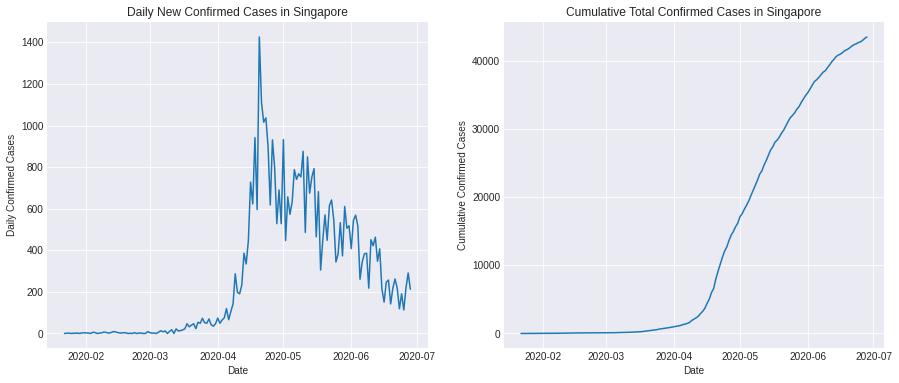

In [5]:
sg = create_country_df('Singapore')

[Text(0, 0.5, 'Log of daily new cases'),
 Text(0.5, 0, 'Days since 2020-01-22'),
 Text(0.5, 1.0, 'Log Daily confirmed cases: Singapore')]

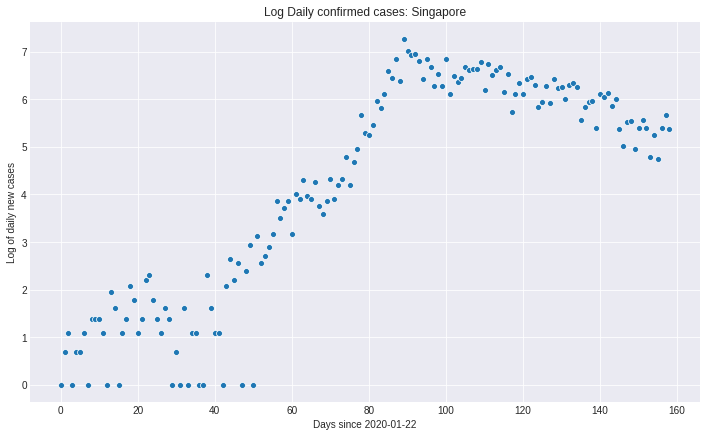

In [6]:
# Get the log of the exponential data so we can fit a linear regression

start_date = sg['date'].min()
sg['days_since_start'] = sg['date'] - start_date
sg['days_since_start'] = sg['days_since_start'].dt.days.astype(int)

plt.figure(figsize=(12, 7))
ax = sns.scatterplot(x=sg['days_since_start'], y=np.log1p(sg['daily_confirmed']))
ax.set(ylabel='Log of daily new cases', xlabel='Days since 2020-01-22',
        title='Log Daily confirmed cases: Singapore')

[Text(0, 0.5, 'Log of daily new cases'),
 Text(0.5, 0, 'Days since 2020-01-22'),
 Text(0.5, 1.0, 'Truncated Log Daily confirmed cases: Singapore')]

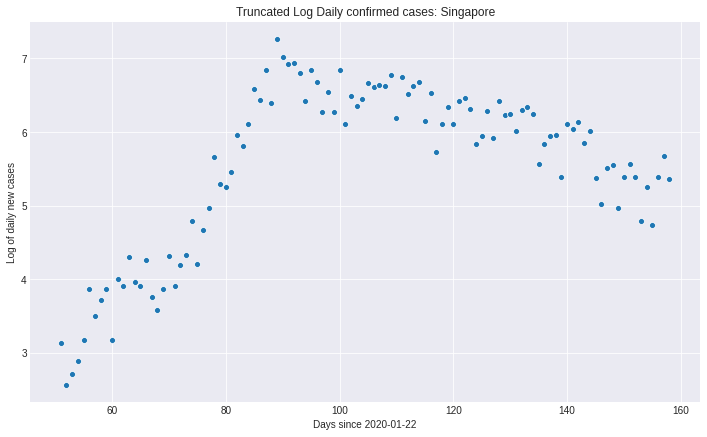

In [7]:
# let's fit a segmented regression model

"""
From visualising the data, there seems to be 3 clusters: one before day 50, 
one after, and one after day 100. We simplify the analysis by only considering
data after day 50.
"""

plt.figure(figsize=(12, 7))
ax = sns.scatterplot(x=sg['days_since_start'][51:], y=np.log1p(sg['daily_confirmed'][51:]))
ax.set(ylabel='Log of daily new cases', xlabel='Days since 2020-01-22',
        title='Truncated Log Daily confirmed cases: Singapore')

In [8]:
np.log1p(sg['daily_confirmed'][51:]).describe()

count    108.000000
mean       5.541798
std        1.138650
min        2.564949
25%        4.793716
50%        5.950643
75%        6.417955
max        7.263330
Name: daily_confirmed, dtype: float64

In [9]:
np.log1p(sg['daily_confirmed'][51:]).quantile(q=[0.25, 0.75])

0.25    4.793716
0.75    6.417955
Name: daily_confirmed, dtype: float64

In [10]:
x = sg['days_since_start'][51:]
y = np.log1p(sg['daily_confirmed'][51:])

In [11]:
b1_mu, b2_mu = np.log1p(sg['daily_confirmed'][51:]).quantile(q=[0.25, 0.75])
with pm.Model() as model:
  sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
  tau = pm.DiscreteUniform('tau', lower=55, upper=150, testval=90)
  # priors for the pre and post switch intercepts and gradients
  w1 = pm.Normal('w1', 0.5, sd=0.25)
  w2 = pm.Normal('w2', 0.0, sd=0.25)
  b1 = pm.Normal('b1', b1_mu, sd=1.0)
  b2 = pm.Normal('b2', b2_mu, sd=b2_mu/4)
  
  w_switch = pm.math.switch(tau < x, w2, w1)
  b_switch = pm.math.switch(tau < x, b2, b1)
  likelihood = pm.Normal('y', mu = w_switch * x + b_switch, sd=sigma, observed=y)

  start = pm.find_MAP()
  step1 = pm.NUTS([w1, w2, b1, b2, sigma])
  step2 = pm.Metropolis([tau])
  trace = pm.sample(20000, tune=1000, step=[step1, step2], start=start, chains=4, progressbar=True)

logp = -73.307, ||grad|| = 1.9304: 100%|██████████| 85/85 [00:00<00:00, 1199.78it/s]  
Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [sigma, b2, b1, w2, w1]
>Metropolis: [tau]
100%|██████████| 21000/21000 [01:48<00:00, 193.31it/s]
The number of effective samples is smaller than 25% for some parameters.


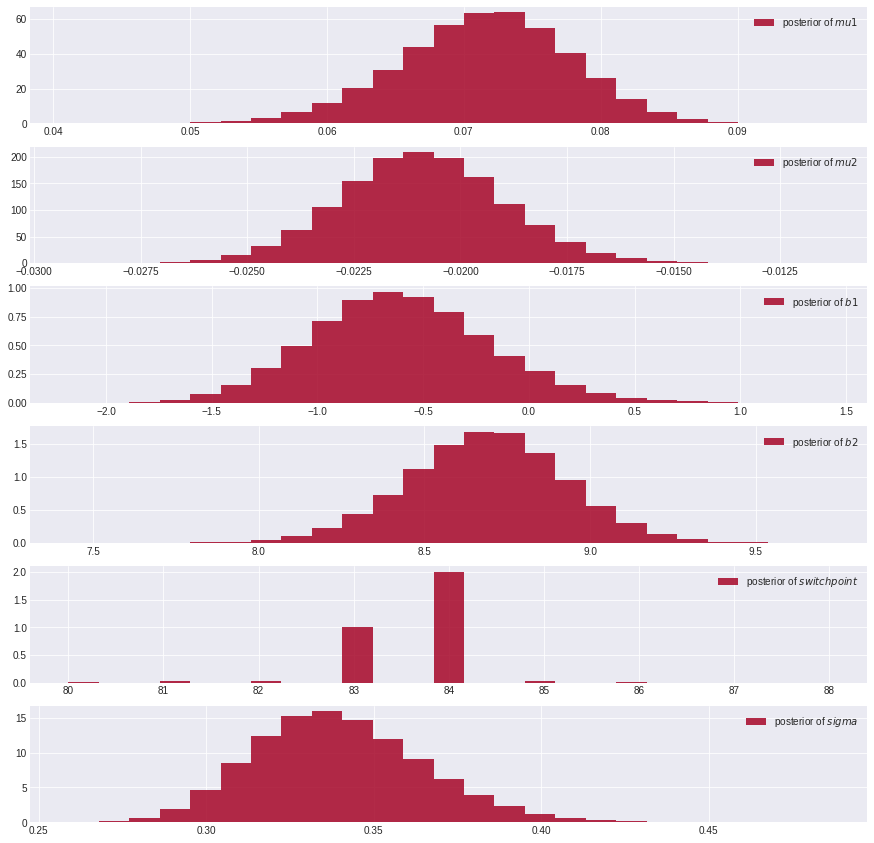

In [12]:
# Analyse the predicted priors

w1_samples = trace['w1'][5000:]
w2_samples = trace['w2'][5000:]
b1_samples = trace['b1'][5000:]
b2_samples = trace['b2'][5000:]
tau_samples = trace['tau']
sigma_samples = trace['sigma']

#histogram of posteriors
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(15, 15))

ax1.hist(w1_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $mu1$", color="#A60628", density=True)
ax1.legend(loc="upper right")

ax2.hist(w2_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $mu2$", color="#A60628", density=True)
ax2.legend(loc="upper right")

ax3.hist(b1_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $b1$", color="#A60628", density=True)
ax3.legend(loc="upper right")

ax4.hist(b2_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $b2$", color="#A60628", density=True)
ax4.legend(loc="upper right")

ax5.hist(tau_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $switchpoint$", color="#A60628", density=True)
ax5.legend(loc="upper right")

ax6.hist(sigma_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $sigma$", color="#A60628", density=True)
ax6.legend(loc="upper right")

Text(0.5, 1.0, 'Switchpoint at x = 84')

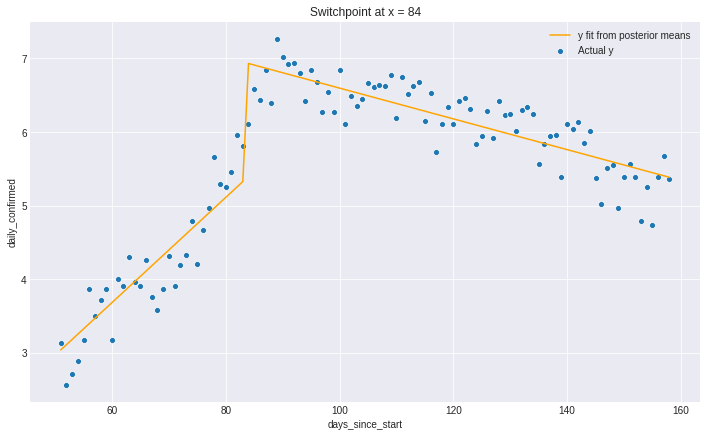

In [13]:
# plot the data
import scipy.stats as scp

w1_pred = w1_samples.mean()
w2_pred = w2_samples.mean()
b1_pred = b1_samples.mean()
b2_pred = b2_samples.mean()
tau_mode, _ = scp.mode(tau_samples)
tau_pred = tau_mode[0]

y_fit = (x < tau_pred) * (b1_pred+w1_pred*x) + (x >= tau_pred)*(b2_pred+w2_pred*x) 

plt.figure(figsize=(12, 7))
sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means')
sns.scatterplot(x, y, label='Actual y')
plt.title(f'Switchpoint at x = {tau_pred}')

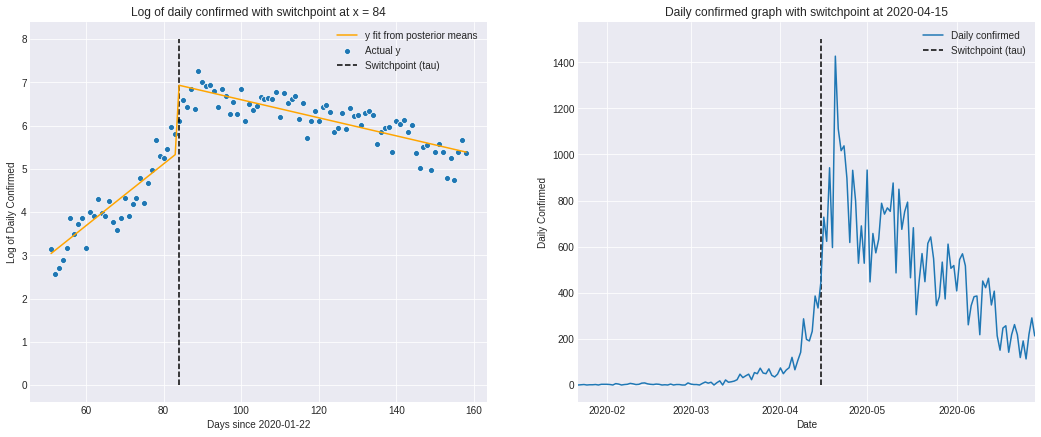

In [14]:
# plot both the log-transformed and original data

from datetime import timedelta

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
             ax=ax1)
sns.scatterplot(x, y, label='Actual y', ax=ax1)
ax1.vlines(tau_pred, 0, 8, linestyle="--", 
           label="Switchpoint (tau)")
ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
        title=f'Log of daily confirmed with switchpoint at x = {tau_pred}')
ax1.legend(loc='upper right')

sns.lineplot(sg['date'], sg['daily_confirmed'],
                label='Daily confirmed', ax=ax2)
ax2.vlines(sg['date'].iloc[0]+timedelta(days=int(tau_pred)), 0, 1500, linestyle="--",
           label="Switchpoint (tau)")
switch_date = sg['date'].iloc[0]+timedelta(days=int(tau_pred))
ax2.set(xlim=[sg['date'].iloc[0], sg['date'].iloc[-1]], xlabel='Date', ylabel='Daily Confirmed',
        title=f'Daily confirmed graph with switchpoint at {switch_date.date()}')
ax2.legend(loc='upper right')

### Generate samples for the following week
- Plot 90% credible interval for old data
- Simulate 90% credible interval forecast
- Plot on the same graph as above

In [15]:
# First we plot the 90% credible intervals for our current data:

sigma_mean = sigma_samples[5000:].mean()

y_samples = np.zeros(shape=(len(y_fit), 100))
for i in range(len(y_fit)):
    y_samples[i, :] = np.random.normal(y_fit.iloc[i], sigma_mean, 100)
    y_samples[i, :] = sorted(y_samples[i, :])

In [16]:
credible_intervals = [(y_samples[i, 5], y_samples[i, 95]) for i in range(y_samples.shape[0])]
lower_bounds = [low for low, _ in credible_intervals]
upper_bounds = [high for _, high in credible_intervals]

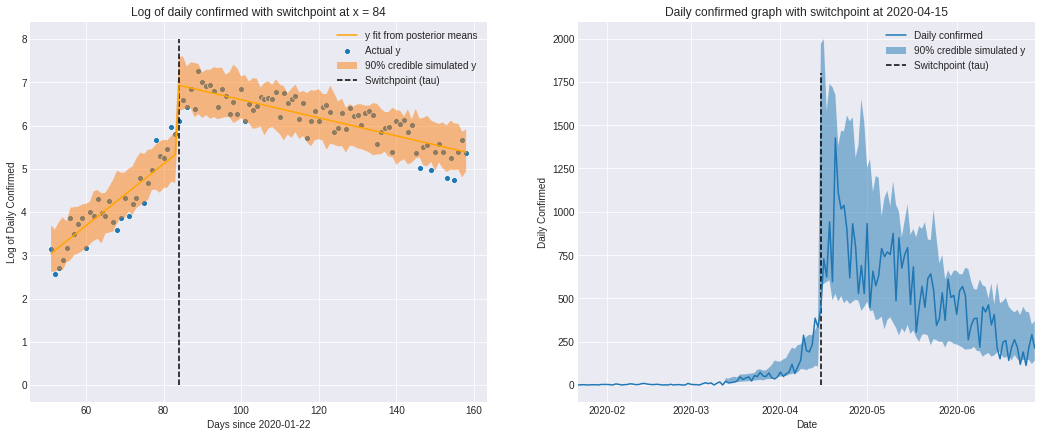

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
             ax=ax1)
sns.scatterplot(x, y, label='Actual y', ax=ax1)
ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                 label='90% credible simulated y')
ax1.vlines(tau_pred, 0, 8, linestyle="--", 
           label="Switchpoint (tau)")
ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
        title=f'Log of daily confirmed with switchpoint at x = {tau_pred}')
ax1.legend(loc='upper right')

sns.lineplot(sg['date'], sg['daily_confirmed'],
                label='Daily confirmed', ax=ax2)
ax2.fill_between(sg['date'][51:], np.exp(lower_bounds), np.exp(upper_bounds), 
                  alpha=0.5, label='90% credible simulated y')
ax2.vlines(sg['date'].iloc[0]+timedelta(days=int(tau_pred)), 0, 1800, linestyle="--",
           label="Switchpoint (tau)")
switch_date = sg['date'].iloc[0]+timedelta(days=int(tau_pred))
ax2.set(xlim=[sg['date'].iloc[0], sg['date'].iloc[-1]], xlabel='Date', ylabel='Daily Confirmed',
        title=f'Daily confirmed graph with switchpoint at {switch_date.date()}')
ax2.legend(loc='upper right')

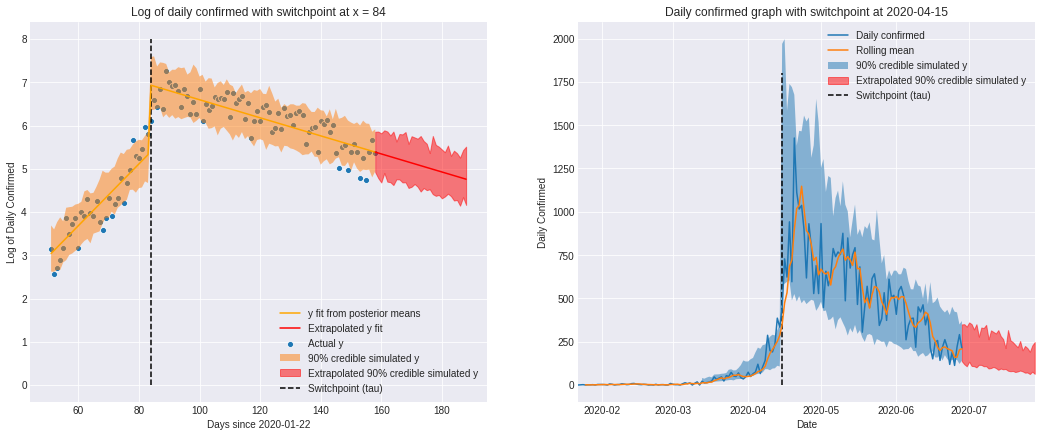

In [18]:
# Then we extrapolate this data out 30 days into the future
from datetime import timedelta

last_day = sg['date'].iloc[-1]
days_after = 30
x_after = np.linspace(x.iloc[-1], x.iloc[-1]+days_after, days_after+1)
dates_after = np.array([last_day + timedelta(days=x) for x in range(days_after+1)])

y_fit_pred = b2_pred + w2_pred * x_after
y_pred_samples = np.zeros(shape=(days_after+1, 100))
for i in range(days_after+1):
    y_pred_samples[i, :] = np.random.normal(y_fit_pred[i], sigma_mean, 100)
    y_pred_samples[i, :] = sorted(y_pred_samples[i, :])

pred_credible_intervals = [(y_pred_samples[i, 5], y_pred_samples[i, 95]) for i in range(days_after+1)]
pred_lower_bounds = [low for low, _ in pred_credible_intervals]
pred_upper_bounds = [high for _, high in pred_credible_intervals]

# Plot the original and extrapolation
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
             ax=ax1)
sns.scatterplot(x, y, label='Actual y', ax=ax1)
sns.lineplot(x_after, y_fit_pred, color='r', label='Extrapolated y fit', ax=ax1)
ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                 label='90% credible simulated y')
ax1.fill_between(x_after, pred_lower_bounds, pred_upper_bounds, alpha=0.5,
                 color='r', label='Extrapolated 90% credible simulated y')
ax1.vlines(tau_pred, 0, 8, linestyle="--", 
           label="Switchpoint (tau)")
ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
        title=f'Log of daily confirmed with switchpoint at x = {tau_pred}')
ax1.legend(loc='lower right')

sns.lineplot(sg['date'], sg['daily_confirmed'],
                label='Daily confirmed', ax=ax2)
sns.lineplot(sg['date'], sg['rolling_mean'], label='Rolling mean', ax=ax2)
ax2.fill_between(sg['date'][51:], np.exp(lower_bounds), np.exp(upper_bounds), 
                  alpha=0.5, label='90% credible simulated y')
ax2.fill_between(dates_after, np.exp(pred_lower_bounds), np.exp(pred_upper_bounds),
                 alpha=0.5, color='r', label='Extrapolated 90% credible simulated y')
ax2.vlines(sg['date'].iloc[0]+timedelta(days=int(tau_pred)), 0, 1800, linestyle="--",
           label="Switchpoint (tau)")
switch_date = sg['date'].iloc[0]+timedelta(days=int(tau_pred))
ax2.set(xlim=[sg['date'].iloc[0], dates_after[-1]], xlabel='Date', ylabel='Daily Confirmed',
        title=f'Daily confirmed graph with switchpoint at {switch_date.date()}')
ax2.legend(loc='upper right')

### TODO:
- Generalize the above into reusable functions
- Sample other countries
- Generalize to k switchpoints in an arbitrary time-series

In [19]:
# View the time series data as a whole and include log data

def create_country_df(country, end_date = '2020-06-28'):
  df = data.loc[data['Country/Region'] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
  df.columns = ['country', 'date', 'confirmed', 'deaths', 'recovered']

  df.groupby(['country', 'date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()
  df.date = pd.to_datetime(df.date)
  df = df.sort_values(by='date')
  df = df[df.date <= end_date]

  # create daily cases
  day_before = np.array([0]+list(df['confirmed'][:-1]))
  daily_confirmed = np.array(df['confirmed']) - day_before
  df['daily_confirmed'] = daily_confirmed

  # create rolling mean
  df['rolling_mean'] = df['daily_confirmed'].rolling(window=4).mean()

  # create log of daily cases
  start_date = df['date'].min()
  df['days_since_start'] = df['date'] - start_date
  df['days_since_start'] = df['days_since_start'].dt.days.astype(int)
  df['log_daily_confirmed'] = np.log1p(df['daily_confirmed'])

  # view confirmed cases
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
  sns.lineplot(x=df.date, y=df.daily_confirmed, ax=ax1)
  ax1.set(ylabel='Daily Confirmed Cases', xlabel='Date',
          title=f'Daily New Confirmed Cases in {country}')
  sns.lineplot(x=df.date, y=df.confirmed, ax=ax2)
  ax2.set(ylabel='Cumulative Confirmed Cases', xlabel='Date',
          title=f'Cumulative Total Confirmed Cases in {country}')
  
  return df

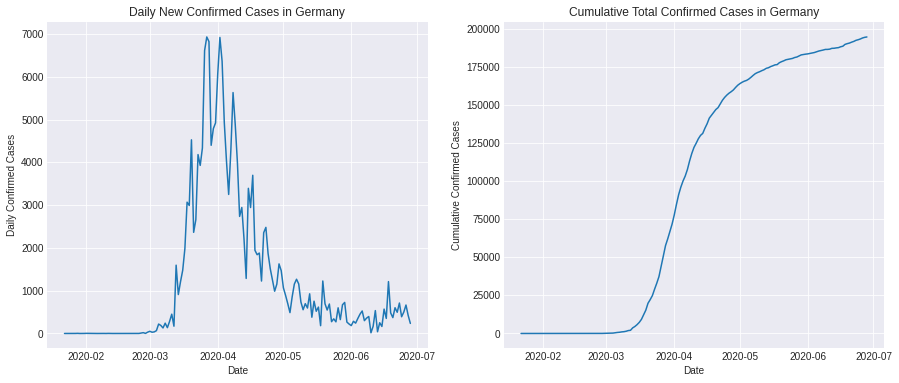

In [20]:
ger = create_country_df('Germany')

In [21]:
def plot_log_cases(df, country_name, start=0, end=-1):
  plt.figure(figsize=(12, 7))
  ax = sns.scatterplot(x=df['days_since_start'].iloc[start:end], y=df['log_daily_confirmed'].iloc[start:end])
  min_date = df['date'].iloc[0].date()
  start_date = df['date'].iloc[start].date()
  end_date = df['date'].iloc[end].date()
  ax.set(ylabel='Log of daily new cases', xlabel=f'Days since {min_date}',
          title=f'Log Daily confirmed cases: {country_name} from {start_date} to {end_date}')

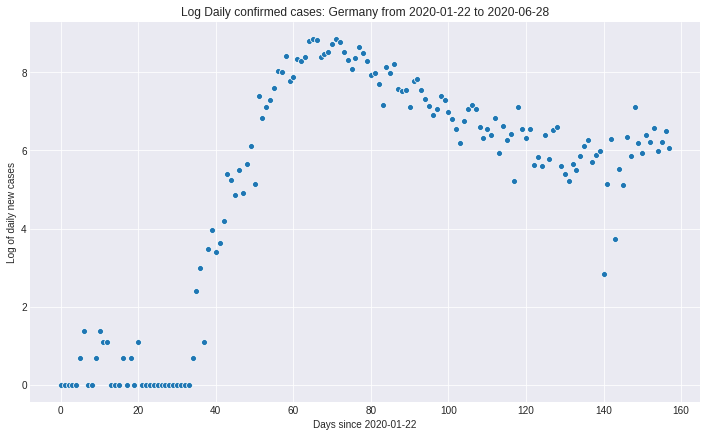

In [22]:
# 3 inflexion points visually seen in Germany's graph.

plot_log_cases(ger, 'Germany')

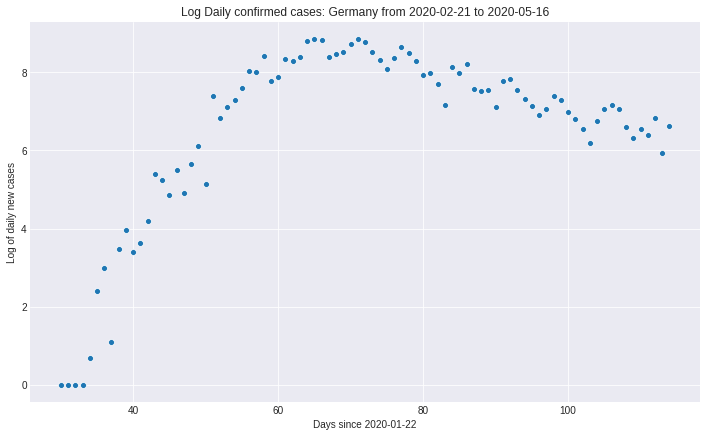

In [23]:
# Let's analyse the middle section

plot_log_cases(ger, 'Germany', start=30, end=115)

In [24]:
# Fit the segmented regression model

def create_model(df, start=0, end=-1):
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]
  b1_mu, b2_mu = y.quantile(q=[0.25, 0.75])

  with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    lower, upper = x.quantile(q=[0.05, 0.95])
    mid = lower+upper/2
    tau = pm.DiscreteUniform('tau', lower=int(lower), upper=int(upper), testval=mid)
    # priors for the pre and post switch intercepts and gradients
    w1 = pm.Normal('w1', 0.5, sd=0.25)
    w2 = pm.Normal('w2', 0.0, sd=0.25)
    b1 = pm.Normal('b1', b1_mu, sd=1.0)
    b2 = pm.Normal('b2', b2_mu, sd=b2_mu/4)
    
    w_switch = pm.math.switch(tau < x, w2, w1)
    b_switch = pm.math.switch(tau < x, b2, b1)
    likelihood = pm.Normal('y', mu = w_switch * x + b_switch, sd=sigma, observed=y)

    start = pm.find_MAP()
    step1 = pm.NUTS([w1, w2, b1, b2, sigma])
    step2 = pm.Metropolis([tau])
    trace = pm.sample(20000, tune=1000, step=[step1, step2], start=start, chains=4, progressbar=True)
    return trace

In [25]:
ger_start = 30
ger_end = 115
ger_trace = create_model(ger, ger_start, ger_end)

logp = -171.23, ||grad|| = 0.19287: 100%|██████████| 60/60 [00:00<00:00, 1592.04it/s]  
Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [sigma, b2, b1, w2, w1]
>Metropolis: [tau]
100%|██████████| 21000/21000 [01:25<00:00, 245.99it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [26]:
def plot_posterior(trace, burn_in=5000):
  w1_samples = trace['w1'][burn_in:] 
  w2_samples = trace['w2'][burn_in:]
  b1_samples = trace['b1'][burn_in:]
  b2_samples = trace['b2'][burn_in:]
  tau_samples = trace['tau']
  sigma_samples = trace['sigma']

  #histogram of posteriors
  fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1, figsize=(15, 15))

  ax1.hist(w1_samples, histtype='stepfilled', bins=25, alpha=0.85,
          label="posterior of $w1$", color="#A60628", density=True)
  ax1.legend(loc="upper right")

  ax2.hist(w2_samples, histtype='stepfilled', bins=25, alpha=0.85,
          label="posterior of $w2$", color="#A60628", density=True)
  ax2.legend(loc="upper right")

  ax3.hist(b1_samples, histtype='stepfilled', bins=25, alpha=0.85,
          label="posterior of $b1$", color="#A60628", density=True)
  ax3.legend(loc="upper right")

  ax4.hist(b2_samples, histtype='stepfilled', bins=25, alpha=0.85,
          label="posterior of $b2$", color="#A60628", density=True)
  ax4.legend(loc="upper right")

  ax5.hist(tau_samples, histtype='stepfilled', bins=25, alpha=0.85,
          label="posterior of $tau$", color="#A60628", density=True)
  ax5.legend(loc="upper right")

  ax6.hist(sigma_samples, histtype='stepfilled', bins=25, alpha=0.85,
          label="posterior of $sigma$", color="#A60628", density=True)
  ax6.legend(loc="upper right")

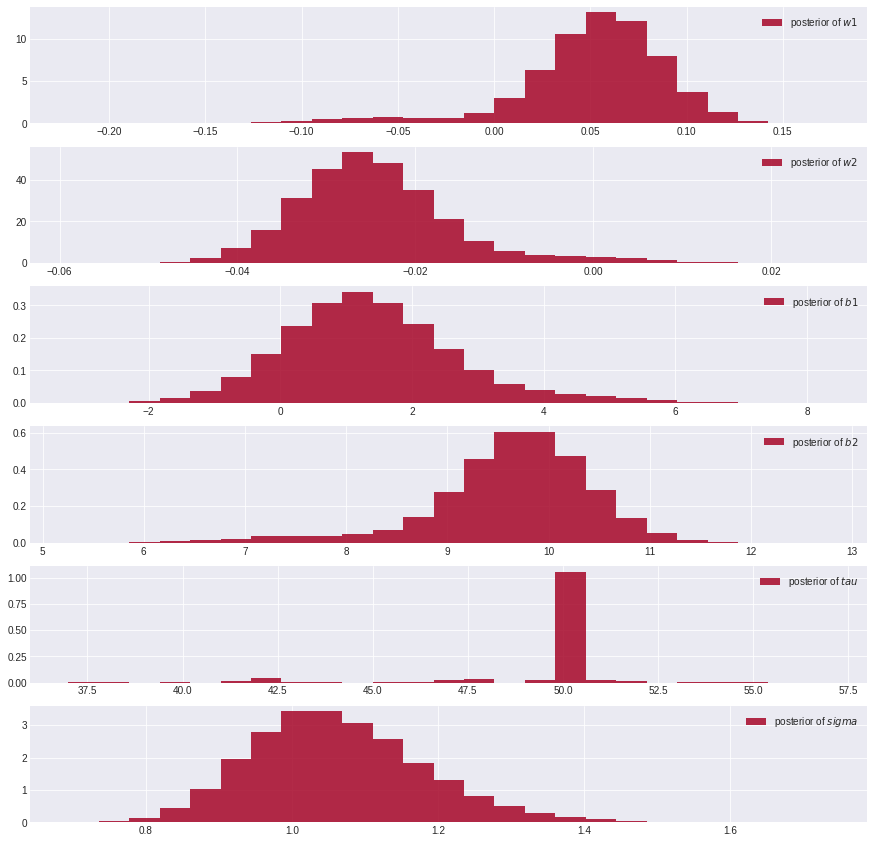

In [27]:
plot_posterior(ger_trace)

In [28]:
def get_y_fit(x, y, trace, burn_in=5000):
  # define samples
  w1_samples = trace['w1'][burn_in:]
  w2_samples = trace['w2'][burn_in:]
  b1_samples = trace['b1'][burn_in:]
  b2_samples = trace['b2'][burn_in:]
  tau_samples = trace['tau']
  sigma_samples = trace['sigma']

  # get expected or mode values
  w1_pred = w1_samples.mean()
  w2_pred = w2_samples.mean()
  b1_pred = b1_samples.mean()
  b2_pred = b2_samples.mean()
  tau_mode, _ = scp.mode(tau_samples)
  tau_pred = tau_mode[0]

  # define y_fit
  y_fit = (x < tau_pred) * (b1_pred+w1_pred*x) + (x >= tau_pred)*(b2_pred+w2_pred*x) 

  # plot y_fit on data
  plt.figure(figsize=(12, 7))
  sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means')
  sns.scatterplot(x, y, label='Actual y')
  plt.title(f'Switchpoint at x = {tau_pred}')

  return y_fit

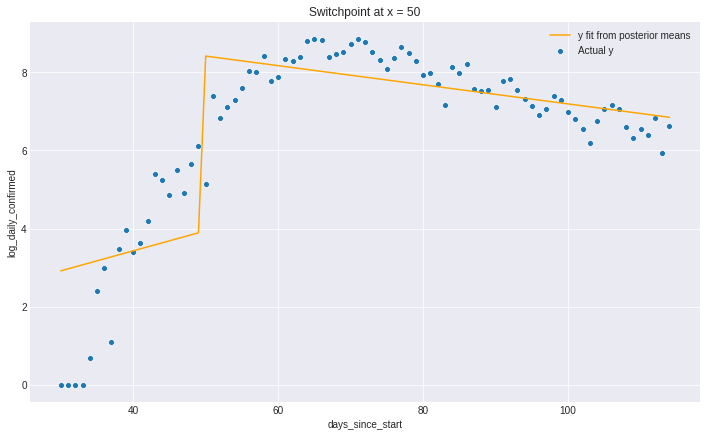

In [29]:
ger_start = 30
ger_end = 115

y_fit = get_y_fit(
    ger['days_since_start'].iloc[ger_start:ger_end],
    ger['log_daily_confirmed'].iloc[ger_start:ger_end],
    ger_trace,
    )

In [30]:
def confidence_intervals(sigma_samples, y_fit, alpha=0.9):
  y_fit = np.array(y_fit)
  sigma_mean = sigma_samples[5000:].mean()
  y_samples = np.zeros(shape=(len(y_fit), 100))
  for i in range(len(y_fit)):
      y_samples[i, :] = np.random.normal(y_fit[i], sigma_mean, 100)
      y_samples[i, :] = sorted(y_samples[i, :])
  low = int((1-alpha) * 100/2)
  high = 100-low 
  credible_intervals = [(y_samples[i, low], y_samples[i, high]) for i in range(len(y_fit))]
  lower_bounds = [low for low, _ in credible_intervals]
  upper_bounds = [high for _, high in credible_intervals]
  return lower_bounds, upper_bounds

def plot_extrapolation(df, trace, start=0, end=-1, days_after=30, burn_in=5000):
  # define x and y
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]

  # define samples
  w1_samples = trace['w1'][burn_in:]
  w2_samples = trace['w2'][burn_in:]
  b1_samples = trace['b1'][burn_in:]
  b2_samples = trace['b2'][burn_in:]
  tau_samples = trace['tau']
  sigma_samples = trace['sigma']

  # get expected or mode values
  w1_pred = w1_samples.mean()
  w2_pred = w2_samples.mean()
  b1_pred = b1_samples.mean()
  b2_pred = b2_samples.mean()
  tau_mode, _ = scp.mode(tau_samples)
  tau_pred = tau_mode[0]

  # define y_fit
  y_fit = (x < tau_pred) * (b1_pred+w1_pred*x) + (x >= tau_pred)*(b2_pred+w2_pred*x)

  # define 90% credible intervals for data
  lower_bounds, upper_bounds = confidence_intervals(sigma_samples, y_fit)

  # define 90% credible intervals for extrapolation
  last_day = df['date'].iloc[end-1]
  x_after = np.linspace(x.iloc[-1], x.iloc[-1]+days_after, days_after+1)
  dates_after = np.array([last_day + timedelta(days=x) for x in range(days_after+1)])
  y_fit_pred = b2_pred + w2_pred * x_after
  pred_lower_bounds, pred_upper_bounds = confidence_intervals(sigma_samples, y_fit_pred)

  # Plot the original and extrapolation
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
  sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
              ax=ax1)
  sns.scatterplot(df['days_since_start'], df['log_daily_confirmed'], label='Actual y', ax=ax1)
  sns.lineplot(x_after, y_fit_pred, color='r', label='Extrapolated y fit', ax=ax1)
  ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                  label='90% credible simulated y')
  ax1.fill_between(x_after, pred_lower_bounds, pred_upper_bounds, alpha=0.5,
                  color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax1.get_ylim()
  ax1.vlines(tau_pred, ymin, ymax, linestyle="--", 
            label="Switchpoint (tau)")
  ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
          title=f'Log of daily confirmed with switchpoint at x = {tau_pred}')
  ax1.legend(loc='upper right')

  sns.lineplot(df['date'], df['daily_confirmed'],
                  label='Daily confirmed', ax=ax2)
  sns.lineplot(df['date'], df['rolling_mean'], label='Rolling mean', ax=ax2)
  ax2.fill_between(df['date'][start:end], np.exp(lower_bounds), np.exp(upper_bounds), 
                    alpha=0.5, label='90% credible simulated y')
  ax2.fill_between(dates_after, np.exp(pred_lower_bounds), np.exp(pred_upper_bounds),
                  alpha=0.5, color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax2.get_ylim()
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(tau_pred)), ymin, ymax, linestyle="--",
            label="Switchpoint (tau)")
  switch_date = df['date'].iloc[0]+timedelta(days=int(tau_pred))
  ax2.set(xlim=[df['date'].iloc[0], dates_after[-1]], xlabel='Date', ylabel='Daily Confirmed',
          title=f'Daily confirmed graph with switchpoint at {switch_date.date()}')
  ax2.legend(loc='upper right')

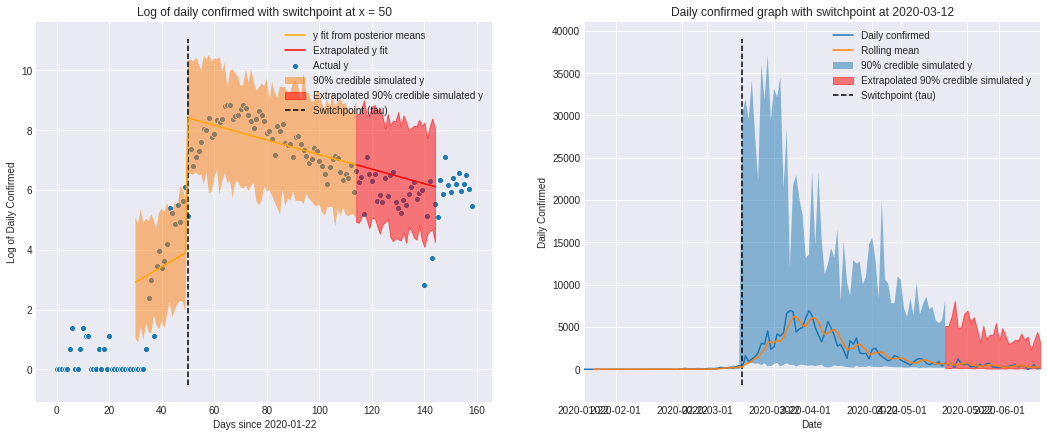

In [31]:
plot_extrapolation(ger, ger_trace, ger_start, ger_end)

In [65]:
def create_k_model(df, k, start=0, end=-1):
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]

  with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)

    # switchpoint array
    s_arr = []
    s_testvals = x.quantile(q=[i/k for i in range(1, k)]).values
    for i in range(k-1):
      s_arr.append(
          pm.DiscreteUniform(
              f's{i+1}',
              lower = x.iloc[0] if not s_arr else s_arr[-1], 
              upper = x.iloc[-1], testval = s_testvals[i]))

    # priors for the pre and post switch intercepts and gradients
    w_arr = []
    b_arr = []
    for i in range(k):
      w_arr.append(pm.Uniform(f'w{i+1}', lower=-10, upper=10))
      b_arr.append(pm.Normal(f'b{i+1}', 0, sd=20))
    
    w_switch_arr = []
    b_switch_arr = []
    for i in range(k-1):
      w_switch_arr.append(
          pm.math.switch(
              s_arr[-(i+1)] < x,
              w_arr[-1] if not w_switch_arr else w_switch_arr[-1],
              w_arr[-(i+2)]))
      b_switch_arr.append(
          pm.math.switch(
              s_arr[-(i+1)] < x,
              b_arr[-1] if not b_switch_arr else b_switch_arr[-1],
              b_arr[-(i+2)]))
    
    likelihood = pm.Normal(
        'y', mu = w_switch_arr[-1] * x + b_switch_arr[-1], sd=sigma, observed=y)

    start = pm.find_MAP()
    nuts_arr = [sigma]
    for i in range(k):
      nuts_arr.append(b_arr[i])
      nuts_arr.append(w_arr[i])

    step1 = pm.NUTS(nuts_arr)
    step2 = pm.Metropolis(s_arr)
    trace = pm.sample(
        20000, tune=1000, step=[step1, step2], 
        start=start, chains=2, progressbar=True, cores=2)
    return trace

In [40]:
# try k=2 on ger data

trace = create_k_model(ger, 2, ger_start, ger_end)

logp = -80.335, ||grad|| = 0.013273: 100%|██████████| 92/92 [00:00<00:00, 1420.82it/s]  
Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [w2, b2, w1, b1, sigma]
>Metropolis: [s1]
100%|██████████| 21000/21000 [01:34<00:00, 222.32it/s]
The number of effective samples is smaller than 10% for some parameters.


In [46]:
# Only for k=2!

def plot_extrapolation(df, trace, start=0, end=-1, days_after=30, burn_in=5000):
  # define x and y
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]

  # define samples
  w1_samples = trace['w1'][burn_in:]
  w2_samples = trace['w2'][burn_in:]
  b1_samples = trace['b1'][burn_in:]
  b2_samples = trace['b2'][burn_in:]
  tau_samples = trace['s1']
  sigma_samples = trace['sigma']

  # get expected or mode values
  w1_pred = w1_samples.mean()
  w2_pred = w2_samples.mean()
  b1_pred = b1_samples.mean()
  b2_pred = b2_samples.mean()
  tau_pred = int(round(tau_samples.mean()))

  # define y_fit
  y_fit = (x < tau_pred) * (b1_pred+w1_pred*x) + (x >= tau_pred)*(b2_pred+w2_pred*x)

  # define 90% credible intervals for data
  lower_bounds, upper_bounds = confidence_intervals(sigma_samples, y_fit)

  # define 90% credible intervals for extrapolation
  last_day = df['date'].iloc[end-1]
  x_after = np.linspace(x.iloc[-1], x.iloc[-1]+days_after, days_after+1)
  dates_after = np.array([last_day + timedelta(days=x) for x in range(days_after+1)])
  y_fit_pred = b2_pred + w2_pred * x_after
  pred_lower_bounds, pred_upper_bounds = confidence_intervals(sigma_samples, y_fit_pred)

  # Plot the original and extrapolation
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
  sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
              ax=ax1)
  sns.scatterplot(df['days_since_start'], df['log_daily_confirmed'], label='Actual y', ax=ax1)
  sns.lineplot(x_after, y_fit_pred, color='r', label='Extrapolated y fit', ax=ax1)
  ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                  label='90% credible simulated y')
  ax1.fill_between(x_after, pred_lower_bounds, pred_upper_bounds, alpha=0.5,
                  color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax1.get_ylim()
  ax1.vlines(tau_pred, ymin, ymax, linestyle="--", 
            label="Switchpoint (tau)")
  ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
          title=f'Log of daily confirmed with switchpoint at x = {tau_pred}')
  ax1.legend(loc='upper right')

  sns.lineplot(df['date'], df['daily_confirmed'],
                  label='Daily confirmed', ax=ax2)
  sns.lineplot(df['date'], df['rolling_mean'], label='Rolling mean', ax=ax2)
  ax2.fill_between(df['date'][start:end], np.exp(lower_bounds), np.exp(upper_bounds), 
                    alpha=0.5, label='90% credible simulated y')
  ax2.fill_between(dates_after, np.exp(pred_lower_bounds), np.exp(pred_upper_bounds),
                  alpha=0.5, color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax2.get_ylim()
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(tau_pred)), ymin, ymax, linestyle="--",
            label="Switchpoint (tau)")
  switch_date = df['date'].iloc[0]+timedelta(days=int(tau_pred))
  ax2.set(xlim=[df['date'].iloc[0], dates_after[-1]], xlabel='Date', ylabel='Daily Confirmed',
          title=f'Daily confirmed graph with switchpoint at {switch_date.date()}')
  ax2.legend(loc='upper right')

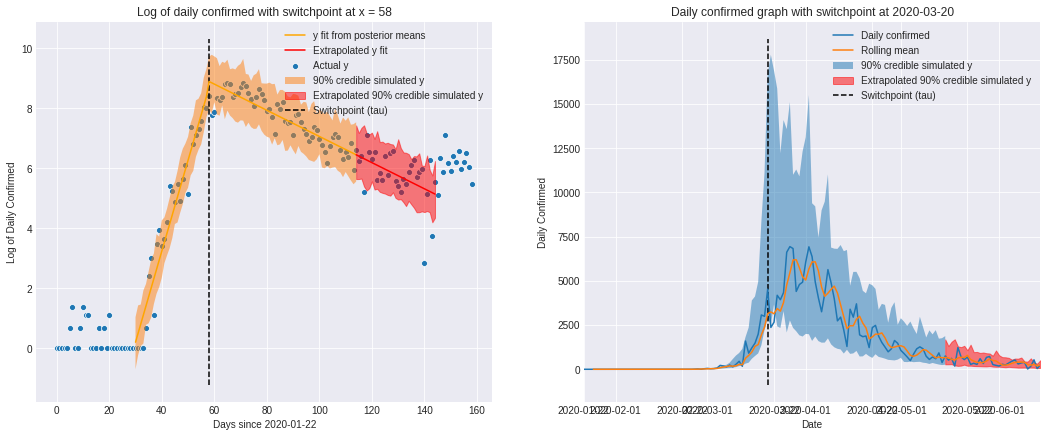

In [47]:
plot_extrapolation(ger, trace, ger_start, ger_end)

In [48]:
# let's try ger_start = 0, ger_end = 140 with k = 3 segments

k = 3
ger_start = 0
ger_end = 140
ger_trace_3 = create_k_model(ger, k, ger_start, ger_end)

logp = -233.44, ||grad|| = 0.6005: 100%|██████████| 123/123 [00:00<00:00, 1415.42it/s] 
Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [w3, b3, w2, b2, w1, b1, sigma]
>CompoundStep
>>Metropolis: [s2]
>>Metropolis: [s1]
100%|██████████| 21000/21000 [12:11<00:00, 28.72it/s] 
There were 5710 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6334068581331391, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5710 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7023007501986799, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [49]:
ger_trace_3_1 = create_k_model(ger, k, ger_start, ger_end)

logp = -233.44, ||grad|| = 0.6005: 100%|██████████| 123/123 [00:00<00:00, 1306.18it/s] 
Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [w3, b3, w2, b2, w1, b1, sigma]
>CompoundStep
>>Metropolis: [s2]
>>Metropolis: [s1]
100%|██████████| 21000/21000 [02:25<00:00, 144.36it/s]
There were 568 divergences after tuning. Increase `target_accept` or reparameterize.
There were 568 divergences after tuning. Increase `target_accept` or reparameterize.
There were 568 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [69]:
# Only for k=3!
from numpy.random import normal

def get_y(x, s, b, w, std=0.1):
  x = np.array(x)
  y = np.zeros(shape=x.shape)
  switch_idx = 0
  for i in range(len(y)):
    if switch_idx < len(s) and x[i] >= s[switch_idx]:
      switch_idx += 1
    y[i] = x[i] * w[switch_idx] + b[switch_idx] + normal(0, std, 1)
  return y 

def get_pred(samples, burn_in=5000):
  return samples[burn_in:].mean()


def plot_extrapolation_3(df, trace, start=0, end=-1, days_after=30, burn_in=5000):
  # define x and y
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]

  # get expected values
  w_preds = [get_pred(w, burn_in) for w in [trace['w1'], trace['w2'], trace['w3']]]
  b_preds = [get_pred(b, burn_in) for b in [trace['b1'], trace['b2'], trace['b3']]]
  s_preds = [int(round(get_pred(s, burn_in))) for s in [trace['s1'], trace['s2']]]
  sigma_samples = trace['sigma'][burn_in:]

  # define y_fit
  y_fit = get_y(x, s_preds, b_preds, w_preds, std=0)

  # define 90% credible intervals for data
  lower_bounds, upper_bounds = confidence_intervals(sigma_samples, y_fit)

  # define 90% credible intervals for extrapolation
  last_day = df['date'].iloc[end-1]
  x_after = np.linspace(x.iloc[-1], x.iloc[-1]+days_after, days_after+1)
  dates_after = np.array([last_day + timedelta(days=x) for x in range(days_after+1)])
  y_fit_pred = b_preds[-1] + w_preds[-1] * x_after
  pred_lower_bounds, pred_upper_bounds = confidence_intervals(sigma_samples, y_fit_pred)

  # Plot the original and extrapolation
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
  sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
              ax=ax1)
  sns.scatterplot(df['days_since_start'], df['log_daily_confirmed'], label='Actual y', ax=ax1)
  sns.lineplot(x_after, y_fit_pred, color='r', label='Extrapolated y fit', ax=ax1)
  ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                  label='90% credible simulated y')
  ax1.fill_between(x_after, pred_lower_bounds, pred_upper_bounds, alpha=0.5,
                  color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax1.get_ylim()
  ax1.vlines(s_preds[0], ymin, ymax, linestyle="--", 
            label="Switchpoint 1")
  ax1.vlines(s_preds[1], ymin, ymax, linestyle="--", 
            label="Switchpoint 2")
  ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
          title=f'Log of daily confirmed with switchpoint at x = {s_preds[0]}, {s_preds[1]}')
  ax1.legend(loc='lower right')

  sns.lineplot(df['date'], df['daily_confirmed'],
                  label='Daily confirmed', ax=ax2)
  sns.lineplot(df['date'], df['rolling_mean'], label='Rolling mean', ax=ax2)
  ax2.fill_between(df['date'][start:end], np.exp(lower_bounds), np.exp(upper_bounds), 
                    alpha=0.5, label='90% credible simulated y')
  ax2.fill_between(dates_after, np.exp(pred_lower_bounds), np.exp(pred_upper_bounds),
                  alpha=0.5, color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax2.get_ylim()
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(s_preds[0])), ymin, ymax, linestyle="--",
            label="Switchpoint 1")
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(s_preds[1])), ymin, ymax, linestyle="--",
            label="Switchpoint 2")
  switch_date_1 = df['date'].iloc[0]+timedelta(days=int(s_preds[0]))
  switch_date_2 = df['date'].iloc[0]+timedelta(days=int(s_preds[1]))
  ax2.set(xlim=[df['date'].iloc[0], dates_after[-1]], xlabel='Date', ylabel='Daily Confirmed',
          title=f'Daily confirmed graph with switchpoint at {switch_date_1.date()} and {switch_date_2.date()}')
  ax2.legend(loc='upper right')

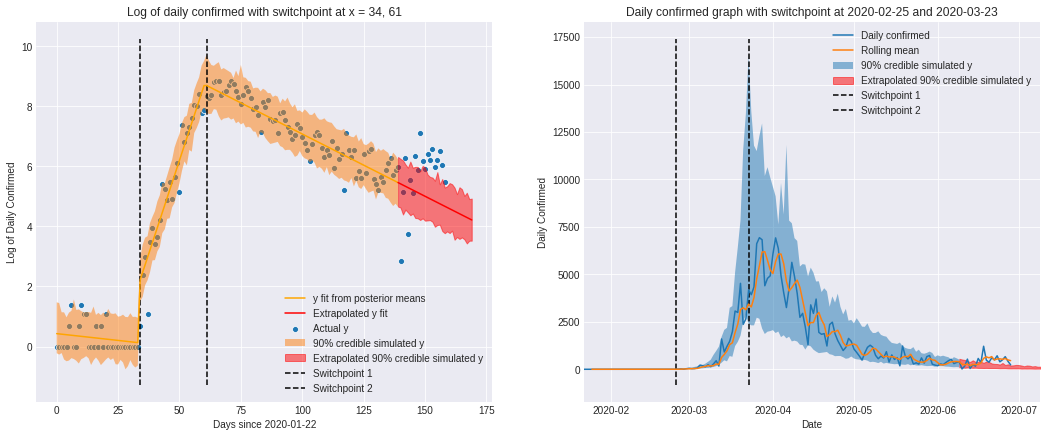

In [59]:
plot_extrapolation_3(ger, ger_trace_3_1, ger_start, ger_end)

In [66]:
# let's try to fit the whole of ger's data with k = 4 segments

k = 4
ger_trace_4 = create_k_model(ger, k)

logp = -219.82, ||grad|| = 1.3128: 100%|██████████| 153/153 [00:00<00:00, 1164.92it/s] 
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [w4, b4, w3, b3, w2, b2, w1, b1, sigma]
>CompoundStep
>>Metropolis: [s3]
>>Metropolis: [s2]
>>Metropolis: [s1]
Sampling 2 chains: 100%|██████████| 42000/42000 [24:36<00:00, 28.45draws/s]
There were 827 divergences after tuning. Increase `target_accept` or reparameterize.
There were 674 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [70]:
def plot_extrapolation_4(df, trace, start=0, end=-1, days_after=30, burn_in=5000):
  # define x and y
  x = df['days_since_start'][start:end]
  y = df['log_daily_confirmed'].iloc[start:end]

  # get expected values
  w_preds = [get_pred(w, burn_in) for w in [trace['w1'], trace['w2'], trace['w3'], trace['w4']]]
  b_preds = [get_pred(b, burn_in) for b in [trace['b1'], trace['b2'], trace['b3'], trace['b4']]]
  s_preds = [int(round(get_pred(s, burn_in))) for s in [trace['s1'], trace['s2'], trace['s3']]]
  sigma_samples = trace['sigma'][burn_in:]

  # define y_fit
  y_fit = get_y(x, s_preds, b_preds, w_preds, std=0)

  # define 90% credible intervals for data
  lower_bounds, upper_bounds = confidence_intervals(sigma_samples, y_fit)

  # define 90% credible intervals for extrapolation
  last_day = df['date'].iloc[end-1]
  x_after = np.linspace(x.iloc[-1], x.iloc[-1]+days_after, days_after+1)
  dates_after = np.array([last_day + timedelta(days=x) for x in range(days_after+1)])
  y_fit_pred = b_preds[-1] + w_preds[-1] * x_after
  pred_lower_bounds, pred_upper_bounds = confidence_intervals(sigma_samples, y_fit_pred)

  # Plot the original and extrapolation
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
  sns.lineplot(x, y_fit, color='orange', label='y fit from posterior means',
              ax=ax1)
  sns.scatterplot(df['days_since_start'], df['log_daily_confirmed'], label='Actual y', ax=ax1)
  sns.lineplot(x_after, y_fit_pred, color='r', label='Extrapolated y fit', ax=ax1)
  ax1.fill_between(x, lower_bounds, upper_bounds, alpha=0.5,
                  label='90% credible simulated y')
  ax1.fill_between(x_after, pred_lower_bounds, pred_upper_bounds, alpha=0.5,
                  color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax1.get_ylim()
  ax1.vlines(s_preds[0], ymin, ymax, linestyle="--", 
            label="Switchpoint 1")
  ax1.vlines(s_preds[1], ymin, ymax, linestyle="--", 
            label="Switchpoint 2")
  ax1.vlines(s_preds[2], ymin, ymax, linestyle="--", 
            label="Switchpoint 3")
  ax1.set(xlabel='Days since 2020-01-22', ylabel='Log of Daily Confirmed',
          title=f'Log of daily confirmed with switchpoint at x = {s_preds[0]}, {s_preds[1]}, {s_preds[2]}')
  ax1.legend(loc='lower right')

  sns.lineplot(df['date'], df['daily_confirmed'],
                  label='Daily confirmed', ax=ax2)
  sns.lineplot(df['date'], df['rolling_mean'], label='Rolling mean', ax=ax2)
  ax2.fill_between(df['date'][start:end], np.exp(lower_bounds), np.exp(upper_bounds), 
                    alpha=0.5, label='90% credible simulated y')
  ax2.fill_between(dates_after, np.exp(pred_lower_bounds), np.exp(pred_upper_bounds),
                  alpha=0.5, color='r', label='Extrapolated 90% credible simulated y')
  ymin, ymax = ax2.get_ylim()
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(s_preds[0])), ymin, ymax, linestyle="--",
            label="Switchpoint 1")
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(s_preds[1])), ymin, ymax, linestyle="--",
            label="Switchpoint 2")
  ax2.vlines(df['date'].iloc[0]+timedelta(days=int(s_preds[2])), ymin, ymax, linestyle="--",
            label="Switchpoint 3")
  switch_date_1 = df['date'].iloc[0]+timedelta(days=int(s_preds[0]))
  switch_date_2 = df['date'].iloc[0]+timedelta(days=int(s_preds[1]))
  switch_date_3 = df['date'].iloc[0]+timedelta(days=int(s_preds[2]))
  ax2.set(xlim=[df['date'].iloc[0], dates_after[-1]], xlabel='Date', ylabel='Daily Confirmed',
          title=f'Daily confirmed graph with switchpoint at {switch_date_1.date()}, {switch_date_2.date()} and {switch_date_3.date()}')
  ax2.legend(loc='upper right')

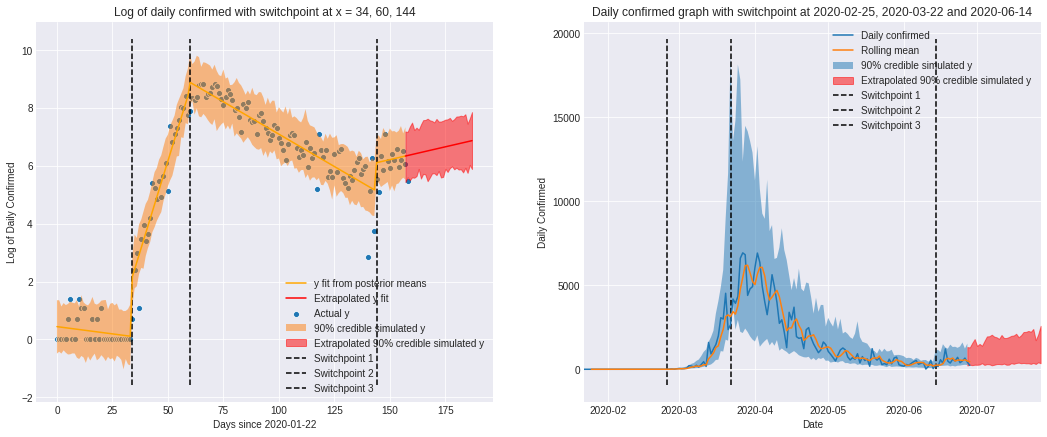

In [71]:
plot_extrapolation_4(ger, ger_trace_4)